In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.io as pio
sns.set_style("whitegrid")
#pio.renderers.default = "browser"
warnings.filterwarnings('ignore')

In [0]:
train = pd.read_csv('/gdrive/My Drive/colab/TimeSeries/dataset/tuto1/Train_SU63ISt.csv')
test = pd.read_csv('/gdrive/My Drive/colab/TimeSeries/dataset/tuto1/Test_0qrQsBZ.csv')

In [0]:
### 1. Datetime column : 'object' type -> 'datetime64' type
train['Datetime'] = pd.to_datetime(train["Datetime"], format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test["Datetime"], format='%d-%m-%Y %H:%M')
# print("train 데이터의 shape: ", train.shape) # (18288, 3)
# print("test 데이터의 shape:", test.shape)    # (5112, 2)

In [0]:
### 2. Add new column 'hour' to train dataframe
train['hour'] = train['Datetime'].dt.hour

In [0]:
### 3. Calculate average hourly fraction
hourly_frac = train.groupby(['hour']).mean() / \
    np.sum(train.groupby(['hour']).mean())
hourly_frac.drop(['ID'], axis=1, inplace=True)
hourly_frac.columns = ['fraction']

In [0]:
### 4. index를 datetime으로 변경
train.index = train.Datetime

In [0]:
### 5. drop columns
train.drop(["ID", "hour", "Datetime"], axis=1, inplace=True)

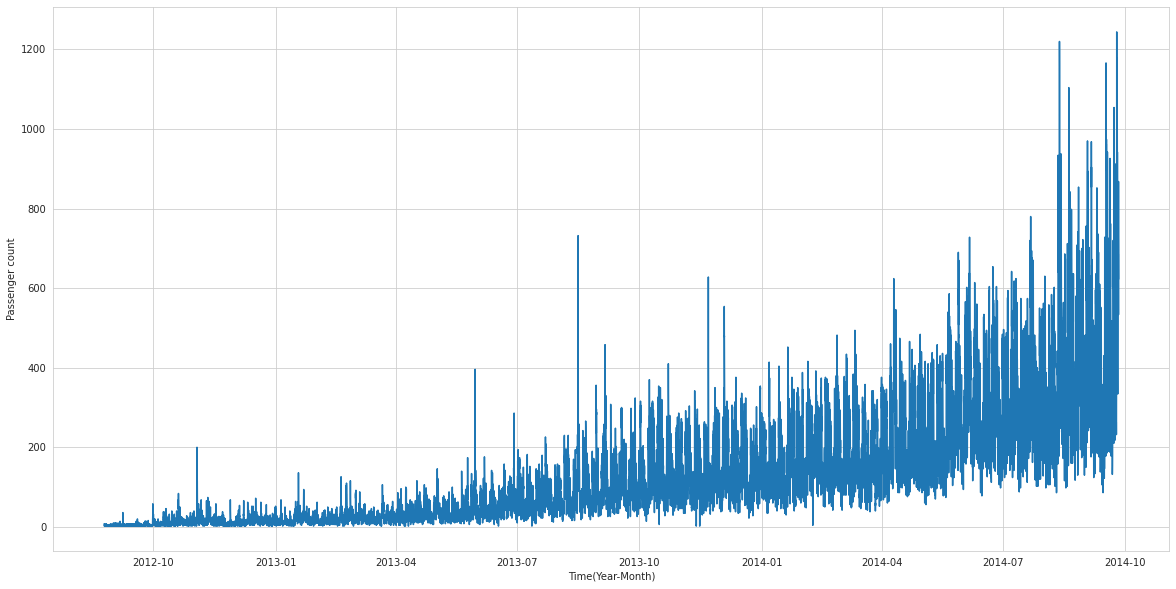

In [12]:
### 6. Visualize train data : hourly 
plt.figure(figsize=(20, 10))
plt.xlabel("Time(Year-Month)")
plt.ylabel("Passenger count")
plt.plot(train, label="Passenger Count")
plt.show()

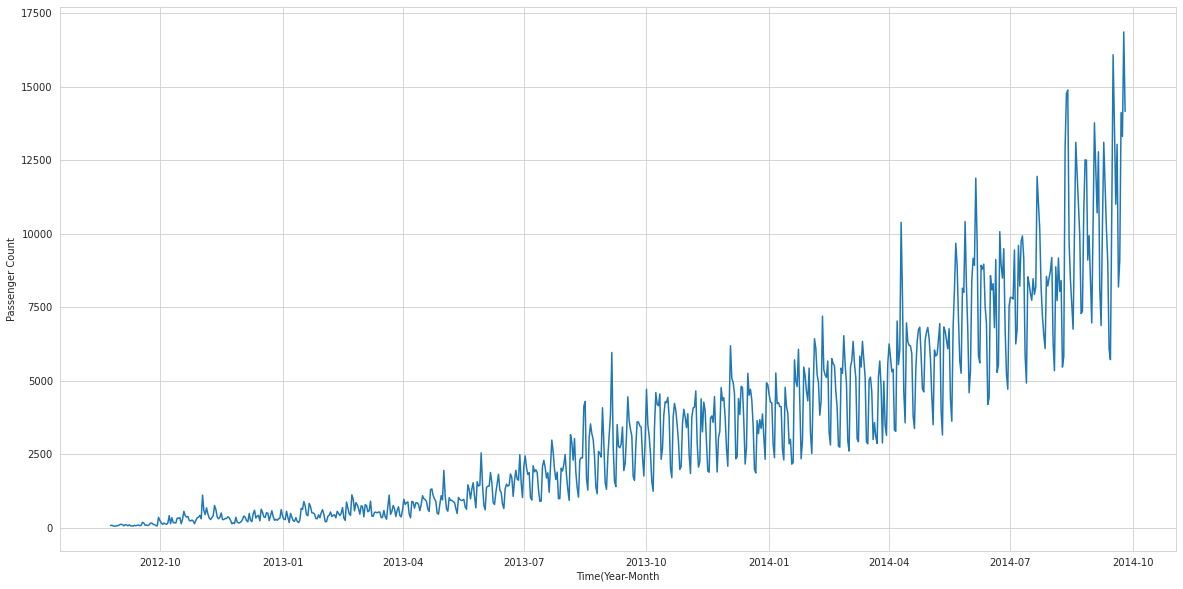

In [15]:
### 7. Visualize train data : daily
daily_train = train.resample('D').sum()

plt.figure(figsize=(20, 10))
plt.xlabel("Time(Year-Month")
plt.ylabel("Passenger Count")
plt.plot(daily_train, label="Passenger Count")
plt.show()
# sns.lineplot(x=daily_train.index, y="Count", data=daily_train)

In [0]:
### 7. Prophet
daily_train['ds'] = daily_train.index
daily_train['y'] = daily_train.Count
daily_train.drop(['Count'], axis=1, inplace=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


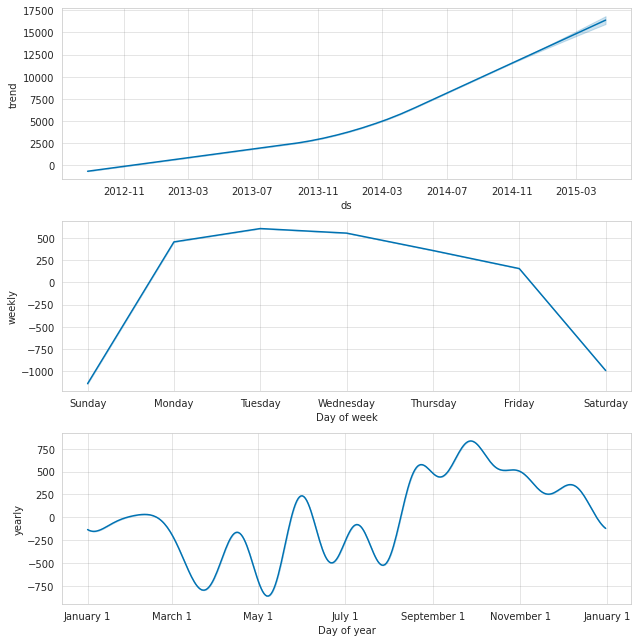

In [18]:
### 8. Prophet fitting
m_passenger = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.3)
m_passenger.fit(daily_train)
future_dataframe = m_passenger.make_future_dataframe(periods=213)
forecast = m_passenger.predict(future_dataframe)

fig = m_passenger.plot_components(forecast)
plt.show()

In [0]:
### 9. Extract hour, day, month and year from both dataframes to merge
forecast = forecast.rename(columns={'ds': 'Datetime'})

for df in [test, forecast]:
    df['hour'] = df['Datetime'].dt.hour
    df['day'] = df['Datetime'].dt.day
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year

test = pd.merge(test, forecast, on=['hour', 'day', 'month', 'year'], how='left')
cols = ['ID', 'hour', 'yhat']
test_new = test[cols]

In [0]:
#######################
test_new = pd.merge(test_new, hourly_frac, left_on=['hour'], right_index=True, how='left')
test_new.fillna(method='ffill', inplace=True)

test_new['Count'] = test_new['yhat'] * test_new['fraction']
test_new.drop(['yhat', 'fraction', 'hour'], axis=1, inplace=True)

test_new.to_csv('prophet_submmistion.csv', index=False)